## Set random seed to get more reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [2]:
import os
import numpy as np
import pandas as pd

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

In [707]:
abu = pd.read_csv('dataFiles/countmatrix.csv', index_col=0)
abu = abu.set_index(abu.index.to_series().str.replace(';Other', ''))
abu = abu.groupby(by=abu.index).sum()
meta = pd.read_csv('dataFiles/metadata.csv').set_index('#SampleID')
meta.index.name = 'SampleID'
meta = meta[~meta.People.str.startswith('TTD')]
meta.loc[meta.Group == 'BJN', 'Env'] = 'root:China'
meta.loc[meta.Group == 'MTC', 'Env'] = 'root:China'
meta.loc[meta.Group == 'MTT', 'Env'] = 'root:Trinidad and Tobago'
meta.loc[meta.Group == 'MTB', 'Env'] = 'root:China'
meta.loc[meta.Group == 'TTC', 'Env'] = 'root:Trinidad and Tobago'
meta.loc[meta.Group == 'TTN', 'Env'] = 'root:Trinidad and Tobago'
#meta['Env'] = meta.apply(lambda x: x['Env'] + ':' + x.Phase if x.name.startswith('MT') else x['Env'], axis=1)
meta['is_MT10'] = (meta.People == 'MT10')

In [710]:
for i in range(1, 11):
    is_source = ~(meta.People == 'MT'+str(i))
    if not os.path.isdir('experiments/exp_{}'.format(i)):
        os.mkdir('experiments/exp_{}'.format(i))
    meta.loc[~is_source, :].reset_index().to_csv('experiments/exp_{}/QueryMapper.csv'.format(i))
    meta.loc[is_source&~meta.is_MT10, :].reset_index().to_csv('experiments/exp_{}/SourceMapper.csv'.format(i))
    abu.loc[:, meta[~is_source].index.tolist()].to_csv('experiments/exp_{}/QueryCM.tsv'.format(i), sep='\t')
    abu.loc[:, meta[is_source&~meta.is_MT10].index.tolist()].to_csv('experiments/exp_{}/SourceCM.tsv'.format(i), sep='\t')

## Construct ontology using mapper file of source samples

In [711]:
!awk -F ',' '{print $9}' experiments/exp_1/SourceMapper.csv | grep -v "Env" | sort | uniq  > microbiomes.txt
!cat microbiomes.txt
!expert construct -i microbiomes.txt -o ontology.pkl

root:China
root:Trinidad and Tobago
Reading microbiome structure...
Generating Ontology...
100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 12175.05it/s]
root
├── root:China
└── root:Trinidad and Tobago

Done


## Preprocess the data, using EXPERT's command-line API 

In [712]:
%%bash

for((i=1; i<11; i++)); do \
ls experiments/exp_$i/QueryCM.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/QueryCM.h5; \
ls experiments/exp_$i/SourceCM.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/SourceCM.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/SourceMapper.csv -o experiments/exp_$i/SourceLabels.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/QueryMapper.csv -o experiments/exp_$i/QueryLabels.h5; \
done
rm tmp

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
           MTC1T1      MTC1T2      MTT1T4  ...      MTT1T8      MTT1T9     MTT1T17
count  629.000000  629.000000  629.000000  ...  629.000000  629.000000  629.000000
mean     0.007941    0.007944    0.007931  ...    0.007945    0.007947    0.007945
std      0.063604    0.063045    0.058586  ...    0.051251    0.049582    0.054776
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max      0.712427    0.693843    0.634973  ...    0.578762    0.648038    0.745457

[6 rows x 11 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/629 entries droped cause they are not in NCBI taxanomy database
Series([], dtype: object)
Extracting lineages for taxonomic 

100%|██████████| 2/2 [00:00<00:00, 30.07it/s]


## Evaluate the model

In [734]:
%%bash
for((i=1; i<11; i++)); do
    #expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_DM \
    #        -m ../Disease-diagnosis/experiments/exp_3/TrainModel/ --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult_Adapt_ft_DM;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_DM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_DM -S 0;
done

Reordering labels and samples...
Total matched samples: 249
Total correct samples: 249?249
           mean       std
0      0.000000  0.000000
1      0.000000  0.000000
2      0.000000  0.000000
3      0.005865  0.034154
4      0.003519  0.020493
...         ...       ...
18013  0.000008  0.000028
18014  0.000000  0.000000
18015  0.000012  0.000055
18016  0.000003  0.000044
18017  0.000000  0.000000

[18018 rows x 2 columns]
Training using optimizer with lr=0.001...
Epoch 1/300
4/4 [==============================] - 1s 169ms/step - loss: 0.8153 - acc: 0.5134 - auROC: 0.5884 - val_loss: 0.7242 - val_acc: 0.5000 - val_auROC: 0.6320
Epoch 2/300
4/4 [==============================] - 0s 30ms/step - loss: 0.7252 - acc: 0.5312 - auROC: 0.4911 - val_loss: 0.6589 - val_acc: 0.6800 - val_auROC: 0.6400
Epoch 3/300
4/4 [==============================] - 0s 13ms/step - loss: 0.6912 - acc: 0.5759 - auROC: 0.5351 - val_loss: 0.6630 - val_acc: 0.6600 - val_auROC: 0.6632
Epoch 4/300
4/4 [=============

2020-12-25 14:08:00.228438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-12-25 14:08:00.236969: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499960000 Hz
2020-12-25 14:08:00.239197: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559da78ec840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-25 14:08:00.239231: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-25 14:08:00.356141: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 73801728 exceeds 10% of free system memory.
2020-12-25 14:08:00.367361: W tensorflow/core/framework/cpu_allocator_impl.cc:81]

CalledProcessError: Command 'b'for((i=1; i<11; i++)); do\n    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_DM \\\n            -m ../Disease-diagnosis/experiments/exp_3/TrainModel/ --finetune --update-statistics;\n    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult_Adapt_ft_DM;\n    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_DM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_DM -S 0;\ndone\n'' returned non-zero exit status 1.

## Visualize the evaluation result

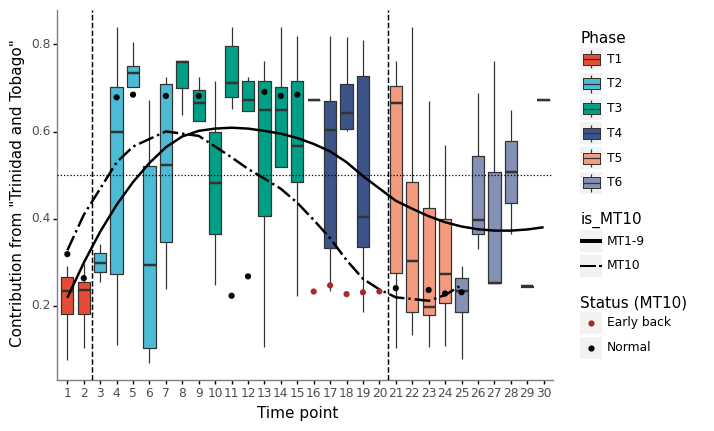

<ggplot: (8783010913549)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure.pdf


In [735]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

suffix = 'Adapt_ft_DM'
contributions = pd.concat([pd.read_csv('experiments/exp_{}/SearchResult_{}/layer-2.csv'.format(i, suffix), index_col=0) for i in range(1, 11)])
metadata = pd.read_csv('dataFiles/metadata.csv').set_index('#SampleID')
contributions = contributions.join(metadata, how='left')
#contributions = contributions[contributions.Phase != 'T6']
#data = contributions.groupby(by=['People', 'Phase'], as_index=False).mean()
contributions['GroupAll'] = '1'
contributions = contributions.sort_values('Timepoint')
contributions['Timepoint_str'] = contributions['Timepoint'].astype(str)
contributions['is_MT10'] = (contributions.People == 'MT10').map({True: 'MT10', False: 'MT1-9'})
data = contributions

T_unique = contributions[['Phase', 'Timepoint']].drop_duplicates()
contributions['Period'] = contributions.Phase.map(T_unique.Phase.value_counts(sort=False).to_dict())
contributions['Status (MT10)'] = 'Normal'
contributions.loc[(contributions.People == 'MT10')&(contributions.Timepoint > 15)&(contributions.Timepoint < 21), 'Status (MT10)'] = 'Early back'

plot = (ggplot(data, aes(x='Timepoint_str', y='root:Trinidad and Tobago'))
        + geom_boxplot(aes(fill='Phase', group='Timepoint_str'), outlier_shape='', show_legend=True, data=data[data.People != 'MT10'])
        #+ geom_violin(aes(fill='Phase', group='Timepoint_str'), show_legend=True, data=data[data.People != 'MT10'], bw=0.1)
        + scale_fill_manual(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])
        #+ geom_boxplot(aes(group='Timepoint_str'), fill='white', alpha=0.5, show_legend=False, outlier_shape='', data=data[data.People != 'MT10'], width=0.4)
        + geom_smooth(aes(linetype='is_MT10', group='is_MT10'), se=False, method='loess', show_legend=True)
        + scale_linetype_manual(['solid', 'dashdot'])
        + geom_point(aes(color='Status (MT10)'), data=data[data.People == 'MT10'])
        + scale_color_manual(['brown', "black"])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
             axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
        + geom_hline(yintercept=0.5, linetype="dotted")
        + geom_vline(xintercept=[2.5, 20.5], linetype="dashed", size=0.6)
        #+ geom_label(data='Early back', position=[15.5, 0.2])
        + scale_x_discrete(limits=contributions['Timepoint_str'].unique())
        + xlab('Time point')
        + ylab('Contribution from "Trinidad and Tobago"')
)

print(plot)
plot.save('Figure.pdf'.format(suffix), dpi=120, width=6.4*1, height=4.8)

In [738]:
from scipy.stats import ttest_ind
for i in range(1, 11):
    print(ttest_ind(data_16_20.loc[(data_16_20.People == 'MT{}'.format(i))&(data_16_20.Group == 'MTT'), 'root:Trinidad and Tobago'], 
                    data_16_20.loc[(data_16_20.People == 'MT{}'.format(i))&(data_16_20.Group == 'MTT'), 'root:China']))

Ttest_indResult(statistic=-0.5327818397656441, pvalue=0.6015066309222087)
Ttest_indResult(statistic=1.0220101050330948, pvalue=0.31898006018972447)
Ttest_indResult(statistic=4.06690102642737, pvalue=0.00044489357943088974)
Ttest_indResult(statistic=2.6235403171387484, pvalue=0.025442662476214083)
Ttest_indResult(statistic=-2.744206836828457, pvalue=0.011840271564764084)
Ttest_indResult(statistic=7.85609573748906, pvalue=1.4765500804871871e-08)
Ttest_indResult(statistic=2.558875837004759, pvalue=0.017229442047329617)
Ttest_indResult(statistic=0.8379415384238925, pvalue=0.4130523563833476)
Ttest_indResult(statistic=3.6589010009032354, pvalue=0.0017956984427735657)
Ttest_indResult(statistic=2.8830981871475583, pvalue=0.010813580256581343)


In [675]:
p = contributions.reset_index().melt(id_vars=['index', 'People', 'Group', 'Phase'], value_vars=['root:China', 'root:Trinidad and Tobago', 'Unknown'])
p

,index,People,Group,Phase,variable,value
0,MTC1T1,MT1,MTC,T1,root:China,0.775153
1,MTC5T1,MT5,MTC,T1,root:China,0.808747
2,MTC6T1,MT6,MTC,T1,root:China,0.780593
3,MTC7T1,MT7,MTC,T1,root:China,0.737699
4,MTC3T1,MT3,MTC,T1,root:China,0.807118
...,...,...,...,...,...,...
556,MTB6T28,MT6,MTB,T6,Unknown,0.025541
557,MTB8T28,MT8,MTB,T6,Unknown,0.000000
558,MTB6T29,MT6,MTB,T6,Unknown,0.031111
559,MTB8T29,MT8,MTB,T6,Unknown,0.061626


In [691]:
p['Location'] = p.Group.map({'MTC': 'China', 'MTT': 'Trinidad and Tobago', 'MTB': 'China'})

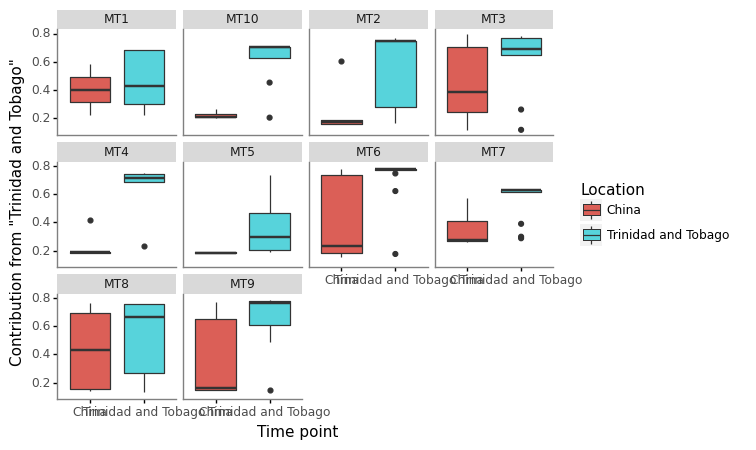

<ggplot: (8782910561603)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_contrib.pdf


In [696]:
plot = (ggplot(p[p.variable=='root:Trinidad and Tobago'], aes(x='Location', y='value', fill='Location'))        
        + geom_boxplot(show_legend=True)
        #+ geom_violin(aes(fill='Phase', group='Timepoint_str'), show_legend=True, data=data[data.People != 'MT10'], bw=0.1)
        #+ scale_fill_manual(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])
        #+ geom_boxplot(aes(group='Timepoint_str'), fill='white', alpha=0.5, show_legend=False, outlier_shape='', data=data[data.People != 'MT10'], width=0.4)
        #+ geom_smooth(aes(linetype='is_MT10', group='is_MT10'), se=False, method='loess', show_legend=True)
        #+ scale_linetype_manual(['solid', 'dashdot'])
        #+ geom_point(aes(color='People'))
        #+ scale_color_manual(['brown', "black"])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
             axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
        + xlab('Time point')
        + ylab('Contribution from "Trinidad and Tobago"')
        #+ coord_flip()
        #+ facet_wrap('Phase')
        + facet_wrap(['People'], nrow=5, ncol=4)
)
print(plot)
plot.save('Figure_contrib.pdf'.format(suffix), dpi=120, width=6.4*1, height=4.8)

In [623]:
taxa = pd.DataFrame(abu.index.to_series().apply(lambda x: dict(map(lambda y: y.split('__'), filter(lambda x: not x.endswith('__'), x.split(';'))))).tolist())

## Plot the data distribution

In [631]:
meta.to_csv('Metadata_PCoA.csv')
abu.to_csv('abundance_PCoA.csv')
!python ../../UniPCoA/UniPCoA.py -i abundance_PCoA.csv -m Metadata_PCoA.csv \
    --metric jensenshannon -o Plots.JSD

#-t ../../UniPCoA/LTPs132_SSU_tree.newick 

Loading data...
Processing the abundance data...
Trying calculating jensenshannon beta_diversity using scikit-bio & scikit-learn package...
This could be time-consuming.
Failed, the metric you selected is not supported by neither scikit-bio nor scikit-learn.
Trying using SciPy...
Succeeded!
Visualizing the data using plotnine package...
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PCoA.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 1 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PC1_boxplot.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: P

In [165]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Adapt_ft_DM'), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, 'Adapt_ft_DM')).dropna()
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))
overall = overall[overall.Metric == 'ROC-AUC'].groupby(by='index', as_index=False).mean().round(4)
overall['index'] = overall['index'].apply(lambda x: x.split(' ')[2].rstrip(')'))
overall['ROC-AUC'] = overall['value']
overall['Stage'] = overall['index']

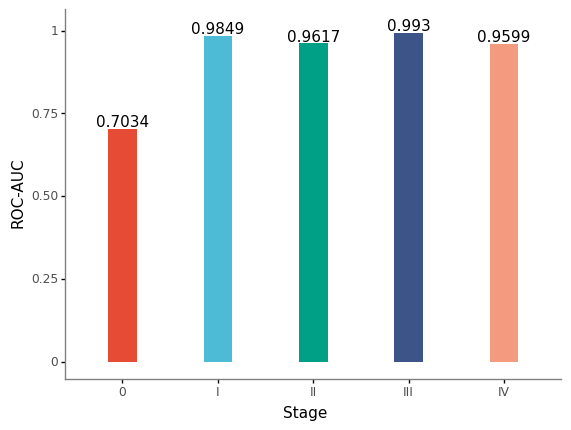

<ggplot: (8737241783248)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3.6 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CRC_stage_performance.pdf


In [166]:
from plotnine import *
plot = (ggplot(overall, aes(x='Stage', y='ROC-AUC', fill='Stage'))
         + geom_bar(stat='identity', width=0.3, show_legend = False)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + geom_text(aes(label='value'), position=position_dodge(width=0.9), nudge_y=0.02)
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
       )
print(plot)
plot.save('CRC_stage_performance.pdf', dpi=120, width=3.6, height=4.8)

In [174]:
pd.read_csv('dataFiles/species_abundance.csv', index_col=0).to_csv('dataFiles/species_abundance.tsv', sep='\t')
!ls dataFiles/species_abundance.tsv > tmp
!expert convert -i tmp -o CRC_cm.h5 --in-cm
!for i in {0,1,2,3,4}; do expert search -i CRC_cm.h5 -o CRC_contribution_$i -m ../Disease-diagnosis/experiments/exp_$i/TrainModel; done

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]
        ERR475482   ERR475493   ERR475500  ...   ERR481063   ERR481064   ERR481065
count  854.000000  854.000000  854.000000  ...  854.000000  854.000000  854.000000
mean     0.188848    0.155293    0.091492  ...    0.221712    0.225143    0.222403
std      2.274977    1.508092    1.018507  ...    4.716516    4.774864    4.758246
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max     47.130700   37.035000   24.845200  ...  135.370960  137.099840  136.803670

[6 rows x 635 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/854 entries droped cause they are not in N